## Experiments using MDL and two-sample KS test for Group Anomaly Detection

In [1]:
import GCA
import random
import numpy as np
import pandas as pd
import numpy.matlib
from numpy import linalg as LA
import math as m
from numpy.linalg import det,inv,norm
from scipy import linalg, stats, sparse
from scipy.sparse import tril
from scipy.special import multigammaln
from scipy.stats import entropy
from scipy.stats import multivariate_normal
from sklearn.utils.extmath import fast_logdet
from sklearn.datasets import make_sparse_spd_matrix
from sklearn.covariance import GraphicalLassoCV, GraphicalLasso
import matplotlib.pyplot as plt
import networkx as nx
import time
import pickle
import copy
import os
import sys
from cvxopt import solvers, matrix, spmatrix, log, mul, blas, lapack, amd, cholmod
#from smcp import completion
#import chompack
import itertools
import torch
import ddks
from decimal import Decimal, getcontext

In [2]:
results_path = 'results/'
if not os.path.exists(results_path):
        os.makedirs(results_path)

In [3]:
"""Functions"""
def covsel(Y):
    """
    Returns the solution of
 
        minimize    -log det K + tr(KY)
        subject to  K_ij = 0  if (i,j) not in zip(I, J).
    Y is a symmetric sparse matrix with nonzero diagonal elements.
    I = Y.I,  J = Y.J.
    """

    cholmod.options['supernodal'] = 2

    I, J = Y.I, Y.J
    n, m = Y.size[0], len(I) 
    # non-zero positions for one-argument indexing 
    N = I + J*n         
    # position of diagonal elements
    D = [ k for k in range(m) if I[k]==J[k] ]  

    # starting point: symmetric identity with nonzero pattern I,J
    K = spmatrix(0.0, I, J) 
    K[::n+1] = 1.0

    # Kn is used in the line search
    Kn = spmatrix(0.0, I, J)

    # symbolic factorization of K 
    F = cholmod.symbolic(K)

    # Kinv will be the inverse of K
    Kinv = matrix(0.0, (n,n))

    for iters in range(100):
        # numeric factorization of K
        cholmod.numeric(K, F)
        d = cholmod.diag(F)

        # compute Kinv by solving K*X = I 
        Kinv[:] = 0.0
        Kinv[::n+1] = 1.0
        cholmod.solve(F, Kinv)
        
        # solve Newton system
        grad = 2 * (Y.V - Kinv[N])
        hess = 2 * ( mul(Kinv[I,J], Kinv[J,I]) + 
               mul(Kinv[I,I], Kinv[J,J]) )
        v = -grad
        lapack.posv(hess,v) 
                                                  
        # stopping criterion
        sqntdecr = -blas.dot(grad,v) 
        #print("Newton decrement squared:%- 7.5e" %sqntdecr)
        if (sqntdecr < 1e-12):
            #print("number of iterations: %d" %(iters+1))
            break

        # line search
        dx = +v
        dx[D] *= 2      
        f = -2.0*sum(log(d))      # f = -log det K
        s = 1
        for lsiter in range(50):
            Kn.V = K.V + s*dx
            try: 
                cholmod.numeric(Kn, F)
            except ArithmeticError: 
                s *= 0.5
            else:
                d = cholmod.diag(F)
                fn = -2.0 * sum(log(d)) + 2*s*blas.dot(v,Y.V)
                if (fn < f - 0.01*s*sqntdecr): break
                else: s *= 0.5

        K.V = Kn.V
    C = np.zeros([K.size[0],K.size[0]])
    for i,j,v in zip(K.I,K.J,K.V):
        C[i,j] = v
        C[j,i] = v
    return inv(C)


def scipy_sparse_to_spmatrix(A):
    coo = A.tocoo()
    SP = spmatrix(coo.data.tolist(), coo.row.tolist(), coo.col.tolist(), size=A.shape)
    return SP

def Codelength_UniversalCoder(n,GG):
    cl= np.zeros(8)
    GG.remove_edges_from(nx.selfloop_edges(GG))
    pg = GCA.CS12s()
    pg.parse(n, GG, update=True)
    cons = n - 0.5 * np.log2(n)
    cl[0] = pg.codelength_bin() 
    cl[1] = pg.codelength_degree() + cons 
    cl[2] = pg.codelength_class1(ctype='tri') 
    cl[3] = pg.codelength_class2(ctype='tri') + cons 
    cl[4] = pg.codelength_class1(ctype='com') 
    cl[5] = pg.codelength_class2(ctype='com') + cons 
    cl[6] = pg.codelength_class1(ctype='4nod') 
    cl[7] = pg.codelength_class2(ctype='4nod')+ cons
    return cl

def Codelength_data(n,GG,X):
    """calculate codelength of data based on estimated covaraince"""
    sigma = []
    A = nx.to_scipy_sparse_matrix(GG)
    A = tril(A)
    A_hat= scipy_sparse_to_spmatrix(A)
    A_adj = nx.adjacency_matrix(GG).todense()
    cl_est = 0
    start = int(1*X.shape[1]) # where to start coding with estimated covariance matrix
    # default distribution for first few samples
    for j in range(start):
        cl_est += 0.5*n*m.log(2*m.pi) + 0.5*np.dot(X[j,:],X[j,:])
    # estimated covariance matrix for the rest of samples   
    for j in range(start, X.shape[0]):
        sigma_emp = np.matmul(X[:j,:].transpose(),X[:j,:])/(j)
        A1= spmatrix([sigma_emp[r,p] for r,p in zip(A_hat.I,A_hat.J)], A_hat.I , A_hat.J)
        sigma_est = covsel(A1)
        prob_est = 0.5*m.log(det(sigma_est)) + 0.5*n*m.log(2*m.pi) + 0.5*np.dot(X[j,:]@inv(sigma_est),X[j,:])
        cl_est += prob_est
    return cl_est*m.log2(m.e)

def Codelength_AllStructures(data, alphaRange):
    prec_CL = []  
    CL_data = []
    CL_graph = []
    for j in alphaRange:
        #print('alpha: ', j)
        Coding = GraphicalLasso(alpha= j , mode='cd',max_iter=100)
        Coding.fit(data)
        prec_ = Coding.precision_
        G_ = nx.Graph(prec_)
    
        prec_CL.append(prec_)
        temp = Codelength_UniversalCoder(prec_.shape[0],G_)
        CL_graph.append(temp)
        
        G_ = nx.Graph(prec_)
        temp2 = Codelength_data(prec_.shape[0],G_,data)
        CL_data.append(temp2)
    
    return prec_CL, CL_data, CL_graph

def covariance_est(GG, X): 
    A = nx.to_scipy_sparse_matrix(GG)
    A = tril(A)
    A_hat= scipy_sparse_to_spmatrix(A)
    A_adj = nx.adjacency_matrix(GG).todense()
    sigma_emp = np.matmul(X.transpose(),X)/X.shape[0]
    A1= spmatrix([sigma_emp[r,p] for r,p in zip(A_hat.I,A_hat.J)], A_hat.I , A_hat.J)
    sigma_ = covsel(A1)
    return sigma_

def Codelength_learned(cov_, X):
    n = cov_.shape[0]
    inv_ = inv(cov_)
    cl_est = X.shape[0] * ( 0.5*m.log(det(cov_)) + 0.5*n*m.log(2*m.pi) )
    for j in range(X.shape[0]):
        cl_est += 0.5*np.dot(X[j,:]@inv_,X[j,:])
    return cl_est*m.log2(m.e)
    

def prec_generation (graph_type, dim, alpha=0.02):
    prec = np.zeros([dim,dim])
    
    if graph_type == 'cycle':
        for i in range(dim):
            for j in range(dim):
                if abs(i-j) == 1: prec[i,j] = 0.45
        prec[0,dim-1]= prec[dim-1,0]=0.45
        prec += np.eye(dim)
    
    elif graph_type == 'AR1':
        for i in range(dim):
            for j in range(dim):
                if abs(i-j) == 1: prec[i,j] = 0.45
        prec += np.eye(dim)
        
    elif graph_type == 'AR2':
        for i in range(dim):
            for j in range(dim):
                if abs(i-j) == 1: prec[i,j] = 0.5
                if abs(i-j) == 2: prec[i,j] = 0.25
        prec += np.eye(dim)
    
    elif graph_type == 'AR3':
        for i in range(dim):
            for j in range(dim):
                if abs(i-j) == 1: prec[i,j] = 0.4
                if abs(i-j) == 2: prec[i,j] = 0.2
                if abs(i-j) == 3: prec[i,j] = 0.2
        prec += np.eye(dim)
    
    
    elif graph_type == 'AR4':
        for i in range(dim):
            for j in range(dim):
                if abs(i-j) == 1: prec[i,j] = 0.4
                if abs(i-j) == 2: prec[i,j] = 0.2
                if abs(i-j) == 3: prec[i,j] = 0.2
                if abs(i-j) == 4: prec[i,j] = 0.1
        prec += np.eye(dim)
        
    elif graph_type == 'ER':
        for i in range(dim-1):
            for j in range(i+1,dim):
                if random.random() <= alpha: prec[i,j] = random.uniform(0.4,0.8)
        prec += prec.transpose()
        w, v = np.linalg.eig(prec)
        prec += (abs(min(w)) + 0.05)*np.eye(dim)
        d = np.sqrt(np.diag(prec))
        prec /= d 
        prec /= d[:, np.newaxis]
    
    elif graph_type == 'Hub':
        tr = 0.01
        n_hubs = 2
        for i in range(dim-1):
            for j in range(i+1,dim):
                if random.random() <= tr:
                    prec[i,j] = 1
        hubs = random.sample(range(dim), n_hubs)
        for i in hubs:
            for j in range(dim):
                if i!=j:
                    if random.random() <= 0.7: prec[i,j] = 1
                    else: prec[i,j] = 0
        for i in range(dim-1):
            for j in range(i+1,dim):
                if i!=j and prec[i,j]==1:
                    if (random.random() <= 0.5): prec[i,j] = random.uniform(-0.75,-0.25)
                    else: prec[i,j] = random.uniform(0.25,0.75)

        prec = 0.5*(prec+prec.transpose())
        w, v = np.linalg.eig(prec)
        prec += (0.1 + abs(min(w)))*np.eye(dim)
        d = np.sqrt(np.diag(prec))
        prec /= d
        prec /= d[:, np.newaxis]
    
    elif graph_type == 'star':
        for i in range(1,dim):
            prec[0,i] = 0.2
            prec[i,0] = 0.2
        prec += np.eye(dim)
    
    return prec

def generate_sample(prec, n_samp, n_feat):
    prng = np.random.RandomState()
    cov = linalg.inv(prec)
    d = np.sqrt(np.diag(cov))
    cov /= d
    cov /= d[:, np.newaxis]
    x = prng.multivariate_normal(np.zeros(n_feat), cov, size=n_samp)
    x -= x.mean(axis=0)
    x /= x.std(axis=0)
    return x

def Standardize_data (X):
    X_ = copy.deepcopy(X)
    X_ -= X_.mean(axis=0)
    X_ /= X_.std(axis=0)
    X_ = np.float64(X_)
    return X_

def roc(c1, c2):
    tauv = np.linspace(min(c1), max(max(c1), min(c2)), 500) # we can add more resolution when max(atypical) set is big
    PFA = []
    PD = []
    for tau in tauv:
        PFA.append(np.count_nonzero(c1 >= tau)/len(c1))
        PD.append(np.count_nonzero(c2 >= tau)/len(c2))
    PFA[0], PD[0] = 1., 1. # to finish at 1
    PFA.append(0), PD.append(0) # to start from 0
    auROC = np.trapz(np.sort(PD), np.sort(PFA))
    return PFA, PD, auROC


def find_range(emp_cov, n_alphas = 10):
    """Find range for lambda"""
    A = np.copy(emp_cov)
    A.flat[::A.shape[0]+1] = 0
    alpha_1 = np.max(np.abs(A))
    alpha_0 = 1e-1 * alpha_1
    range_ = np.logspace(np.log10(alpha_0), np.log10(alpha_1) , n_alphas)
    return range_

def OneDKS(t, p):
    ds = []
    for d in range(p.shape[1]):
        ds.append(calculation(p[:, d].unsqueeze(-1), t[:, d].unsqueeze(-1)))
    return max(ds)

def unique_models(data, alphaRange):
    cov = []
    Gs = set()
    for j in alphaRange:
        model = GraphicalLasso(alpha= j , mode='cd',max_iter=100)
        model.fit(data)
        G = nx.Graph(model.precision_)
        edges_list = frozenset(G.edges())
        if edges_list not in Gs:
            Gs.add(edges_list)
            cov.append(covariance_est(G, data))
    return cov

def Codelength_UniqueStructures(data, alphaRange):
    """By initializing covariance matrix for Dempster method and also block coding"""
    cl_data = []
    cl_graph = []
    Gs = set()
    for j in alphaRange:
        Coding = GraphicalLasso(alpha= j , mode='cd',max_iter=100)
        Coding.fit(data)
        prec_ = Coding.precision_
        G_ = nx.Graph(prec_)
        
        edges_list = frozenset(G_.edges())
        if edges_list not in Gs:
            Gs.add(edges_list)
            cl_g = Codelength_UniversalCoder(prec_.shape[0],G_)
            cl_graph.append(cl_g)
            G_ = nx.Graph(prec_)
            cl_d = Codelength_data(prec_.shape[0], G_, data)
            cl_data.append(cl_d)
    
    return cl_data, cl_graph

def combining_cl(CL_n, CL_a, idx, g=0):
    """ soft combining
    g: index graph coder
    idx: index of case"""
    # Set the precision to a sufficiently high value
    getcontext().prec = 100
    
    g_u = [[CL_n[j][2][l][g] for l in range(len(CL_n[j][2]))] for j in range(len(CL_n))]
    d_u = [[CL_n[j][1][l] for l in range(len(CL_n[j][1]))] for j in range(len(CL_n))]
    gd_u = [[g_u[i][j]+ d_u[i][j] for j in range(len(g_u[i]))] for i in range(len(g_u))]
    p_u_glasso = [sum(Decimal(2) ** Decimal(-j) for j in gd_u[i]) for i in range(len(gd_u))]
    cl_u_glasso = [float(-i.logb() * Decimal(m.log2(10))) for i in p_u_glasso]
    cl_l = [CL_n[j][0][0] for j in range(len(CL_n))]
    norm = [i-j for i,j in zip(cl_l, cl_u_glasso)]
    
    g_u = [[CL_a[j][2][l][g] for l in range(len(CL_a[j][2]))] for j in range(len(CL_a))]
    d_u = [[CL_a[j][1][l] for l in range(len(CL_a[j][1]))] for j in range(len(CL_a))]
    gd_u = [[g_u[i][j]+ d_u[i][j] for j in range(len(g_u[i]))] for i in range(len(g_u))]
    p_u_glasso = [sum(Decimal(2) ** Decimal(-j) for j in gd_u[i]) for i in range(len(gd_u))]
    cl_u_glasso = [float(-i.logb() * Decimal(m.log2(10))) for i in p_u_glasso]
    cl_l = [CL_a[j][0][0] for j in range(len(CL_a))]
    anom = [i-j for i,j in zip(cl_l, cl_u_glasso)]
    
    return [norm, anom]

def generate_data(size, case=1, normal=True, random_state=True):
    if random_state:
        prng = np.random.RandomState()
    else:
        prng = np.random.RandomState(100)

    if normal:
        A = prec_generation(graph_type[2], 6)
    else:
        A = prec_generation(graph_type[3], 6)

    data = pd.DataFrame(columns=['A', 'B', 'C', 'D', 'E', 'F'])

    if case == 1:
        data['A'] = prng.laplace(0, 1, size)
        data['B'] = prng.laplace(0, 2, size)
        data['C'] = prng.laplace(0, 3, size)
        data['D'] = prng.laplace(0, 4, size)
        data['E'] = prng.laplace(0, 5, size)
        data['F'] = prng.laplace(0, 6, size)
    elif case == 2:
        data['A'] = prng.logistic(0, 1, size)
        data['B'] = prng.logistic(0, 2, size)
        data['C'] = prng.logistic(0, 3, size)
        data['D'] = prng.logistic(0, 4, size)
        data['E'] = prng.logistic(0, 5, size)
        data['F'] = prng.logistic(0, 6, size)
    elif case == 3:
        data['A'] = prng.standard_t(5, size)
        data['B'] = prng.standard_t(6, size)
        data['C'] = prng.standard_t(7, size)
        data['D'] = prng.standard_t(8, size)
        data['E'] = prng.standard_t(9, size)
        data['F'] = prng.standard_t(10, size)
    elif case == 4:
        data['A'] = prng.chisquare(5, size)
        data['B'] = prng.chisquare(6, size)
        data['C'] = prng.chisquare(7, size)
        data['D'] = prng.chisquare(8, size)
        data['E'] = prng.chisquare(9, size)
        data['F'] = prng.chisquare(10, size)
    else:
        raise ValueError(f"Unsupported case type: {case}")

    X = np.asarray(data)
    return np.dot(X, A)

In [4]:
"""Main function"""
# select case
cases = [1, 2, 3, 4]
case = cases[0]

iters = 500
n_features = 6
train_size = 1000
test_size = 50
CL_n = []
KS_n = []
CL_a = []
KS_a = []
calculation = ddks.methods.ddKS()
graph_type = ['cycle', 'AR1', 'AR2', 'AR3', 'AR4', 'ER', 'Hub', 'star'] # type of sparse graphs
#################################################################################################

t0 = time.time()
"""train step"""
X_train = generate_data(size=train_size, case=case, normal=True)
X_train_tensor = torch.from_numpy(X_train) # tensor version of data
X_train = Standardize_data(X_train)

emp_cov = np.dot(X_train.T, X_train) / X_train.shape[0]
alpha = find_range(emp_cov, n_alphas=10) #regularization parameter for graphical lasso
prec, cl_data, cl_graph = Codelength_AllStructures(X_train, alpha)
idx = [0]*8
cov = [] # estimated covariance with Depmpster method
for d in range(8):
    idx[d] = np.argmin([i+j for i,j in zip(cl_data, [cl[d] for cl in cl_graph])])
    # estimate covariance based on learned graph structure
    G = nx.Graph(prec[idx[d]])
    cov.append(covariance_est(G, X_train))   

########################################################################################
"""test step"""
for i in range(iters):
    if(i%50 == 0): print("iter:", i)
    "generate test data"
    X_test_n = generate_data(size=test_size, case=case, normal=True) # normal test data
    X_test_n_tensor = torch.from_numpy(X_test_n) # tensor version of data
    X_test_n = Standardize_data(X_test_n)
    
    
    X_test_a = generate_data(size=test_size, case=case, normal=False) # anomalous test data 
    X_test_a_tensor = torch.from_numpy(X_test_a) # tensor version of data
    X_test_a = Standardize_data(X_test_a)

    "test on normal data"
    # encode with universal glasso coder
    emp_cov = np.dot(X_test_n.T, X_test_n) / X_test_n.shape[0]
    alpha = find_range(emp_cov, n_alphas=10) #regularization parameter for graphical lasso
    CL_data, CL_graph = Codelength_UniqueStructures(X_test_n, alpha)
    # encode with learned glasso coder
    CL_learn = np.zeros(8)
    for d in range(8):
        CL_learn[d] = Codelength_learned(cov[d], X_test_n)
    
    CL_n.append([CL_learn, CL_data, CL_graph])
    
    "test on anomalous data"
    # encode with universal glasso coder
    emp_cov = np.dot(X_test_a.T, X_test_a) / X_test_a.shape[0]
    alpha = find_range(emp_cov, n_alphas=10) #regularization parameter for graphical lasso
    CL_data, CL_graph = Codelength_UniqueStructures(X_test_a, alpha)
    # encode with learned glasso coder
    CL_learn = np.zeros(8)
    for d in range(8):
        CL_learn[d] = Codelength_learned(cov[d], X_test_a)
    CL_a.append([CL_learn, CL_data, CL_graph])

    
    "test using KS test"
    # multi-dimensional KS test
    KS_n.append(calculation(X_train_tensor, X_test_n_tensor).item())
    KS_a.append(calculation(X_train_tensor, X_test_a_tensor).item())
    
print("total time: ",time.time() - t0)

iter: 0
iter: 50
iter: 100
iter: 150
iter: 200
iter: 250
iter: 300
iter: 350
iter: 400
iter: 450
total time:  349.95024251937866


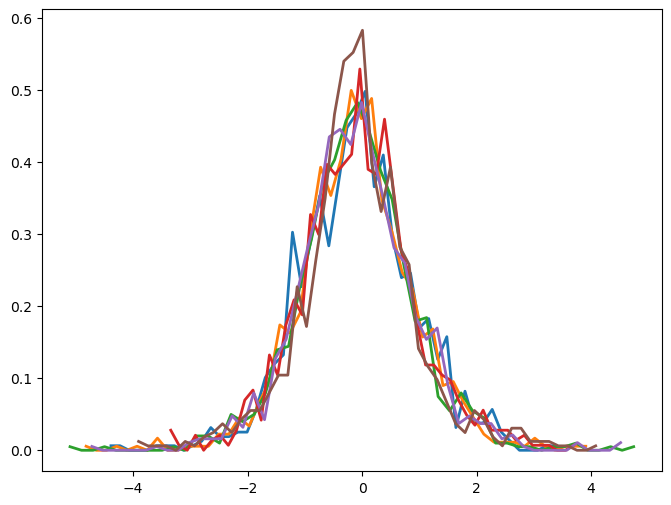

In [5]:
"plot training data"
plt.figure(figsize=(8,6))
for i in range(X_train.shape[1]):
    hist, bins = np.histogram(X_train[:,i], bins=50, density=True)
    plt.plot(bins[:-1], hist, linewidth=2)
plt.show()

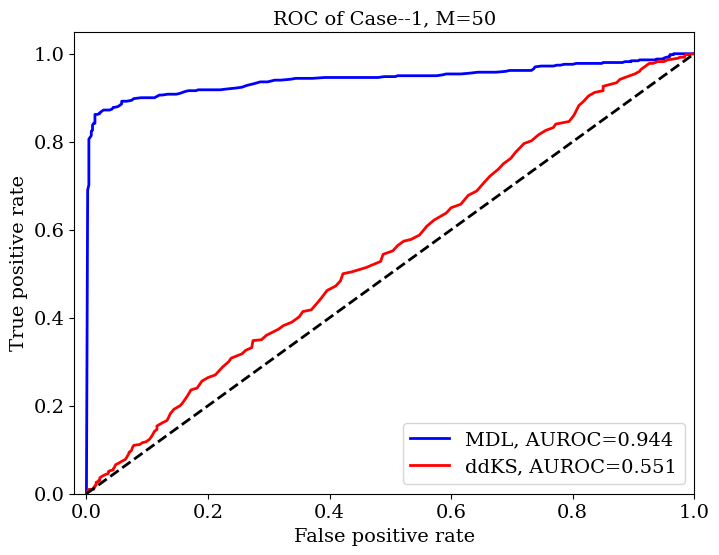

In [9]:
"plot ROC curve"
mdl = combining_cl(CL_n, CL_a, idx, g=2)
fpr1, tp1, AUROC1 = roc(mdl[0], mdl[1])
fpr2, tp2, AUROC2 = roc(KS_n, KS_a)

plt.rcParams["font.family"] = "serif"
plt.rcParams.update({'font.size': 14})
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 14
plt.figure(figsize=(8,6))
plt.plot(fpr1, tp1, 'b', lw=2)
plt.plot(fpr2, tp2, 'r', lw=2)
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([-0.02, 1.0])
plt.ylim([0.0, 1.05])
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.legend(['MDL, AUROC=%.3f'%AUROC1, 
            'ddKS, AUROC=%.3f'%AUROC2], loc='lower right')
plt.title('ROC of Case--%s, M=%s'%(case, test_size))
plt.savefig(results_path+f'/%s_M%s.pdf'%(case, test_size))
plt.show()